In [6]:
import numpy as np
from scipy.io import loadmat
from scipy.fftpack import fft
from scipy.signal import welch
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
sns.set_style("whitegrid")


In [7]:
# Funciones auxiliares para levantar data
def armarNombre(x):
    c = 'S' if x < 11 else 'P'
    x = (x-1)%10+1
    return str(c) + ("" if x == 10 else "0") + str(x)

def armarNombreArchivo(c, x):
    return "data/" + str(c) + ("" if x == 10 else "0") + str(x) + ".mat"

In [8]:
# Funcion auxiliar para pasar valores de frecuencia a bines
#    Delta < 4 Hz
#    4 Hz <= Theta < 8 Hz
#    8 Hz <= Alpha < 13 Hz
#    13 Hz <= Beta < 30 Hz
#    30 Hz <= Gamma < Nyquist

def nombre_banda(x):
    if x < 4:
        return 'Delta'
    elif x < 8:
        return 'Theta'
    elif x < 13:
        return 'Alpha'
    elif x < 30:
        return 'Beta'
    else:
        return 'Gamma'
    





def bin_de_frecuencia(x):
    if x < 4.:
        return 0
    elif x < 8.:
        return 1
    elif x < 13.:
        return 2
    elif x < 30.:
        return 3
    else:
        return 4
    
def agrupar_por_bines(potencias, frecuencias):
    res = np.zeros(5)
    for i in range(len(potencias)):
        res[bin_de_frecuencia(frecuencias[i])] += potencias[i]
    return res

In [9]:
pacientes_raw = {}
for f in os.listdir('./data'):
    fname = "./data/"+f 
    print(f[:-4] + ' -- cargado')
    pacientes_raw[f[:-4]] = (loadmat(fname)['data'])
    

P10 -- cargado
P05 -- cargado
P01 -- cargado
P02 -- cargado
S10 -- cargado
S02 -- cargado
P07 -- cargado
S01 -- cargado


In [10]:
welches = {}
acum_electrodo = np.array([0]*201)
normalizador = (lambda x : x/256)
vnormalizador = np.vectorize(normalizador)

for paciente in pacientes_raw:
    epochi = 0
    welches[paciente] = {}
    for epoch in pacientes_raw[paciente]:
        welches[paciente][epochi] = {}
        for electrodo in epoch:
            arr_electrodo = np.array(electrodo)
            acum_electrodo = np.sum([acum_electrodo,arr_electrodo],axis=0)
        acum_electrodo = vnormalizador(acum_electrodo)
        welches[paciente][epochi] = welch(acum_electrodo,fs= 201/1.54)
        epochi +=1
    print(paciente + ' Welcheado ')

/home/marto/.local/lib/python3.5/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


P10 Welcheado 
P02 Welcheado 
S02 Welcheado 
P01 Welcheado 
S10 Welcheado 
P05 Welcheado 
S01 Welcheado 
P07 Welcheado 


In [49]:
bandas = {0:{},1:{}}
for paciente_k, paciente_v in welches.items():
    if paciente_k.startswith('P'):
        label = 0
    else:
        label = 1
    for epoch_k,epoch_v in paciente_v.items():
        for i in range(len(epoch_v[0])):
            try:
                bandas[label][nombre_banda(epoch_v[0][i])].append(epoch_v[1][i])
            except KeyError:
                bandas[label][nombre_banda(epoch_v[0][i])] = [epoch_v[1][i]]

print(len(bandas[0]['Beta']))
print(len(bandas[1]['Beta']))

112216
47606


In [54]:
def roc_banda(label,x,y,color):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5,random_state=0)


    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0],-1)
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0],-1)

    # print(X_test)


    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train) 



    y_score = neigh.predict_proba(X_test)
   # print(y_score[0])
    y_score = y_score[:,[1]].flatten()
    fpr,tpr,thresholds = roc_curve(y_test,y_score) 
    roc_auc =  auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color,
             lw=2, label='['+label+']ROC curve (area = %0.2f)' % roc_auc)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")




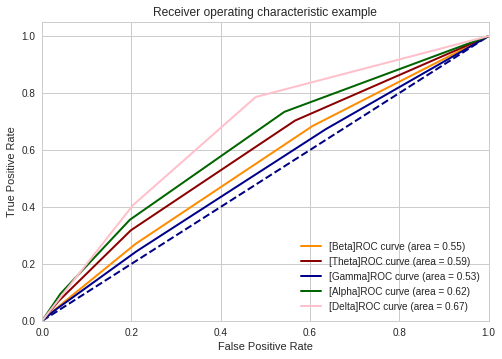

In [55]:
plt.clf()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
colores = ['darkorange','darkred','darkblue','darkgreen','pink','yellow','purple','black']
color = 0
data_roc = {}
for k,l in bandas.items():
    for label in l: 
        if not label in data_roc.keys():
            data_roc[label] = {'x' : [], 'y' : []}
        for v in l[label]:
            data_roc[label]['x']
            data_roc[label]['x'].append(v)
            data_roc[label]['y'].append(k)
            
for k,v in data_roc.items():
    col = colores[color]
    roc_banda(k,v['x'],v['y'],col)
    color+=1
plt.show()


In [37]:
plt.show()